# Analyze Melanoma Patient 78

Here we perform analysis on the gene expressions of cells from the melanoma patient number 78. 
For simplicity we have converted the dataset into TPM.
The original count data is available at Gene Expression Omnibus: [GSE72056](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE72056).

## Import necessary packages

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import sys

import pandas as pd
import numpy as np
import pickle as pkl
import sklearn as skl
import sklearn.preprocessing
import scipy.stats

import matplotlib as mpl

import matplotlib.pyplot as plt

Warning information from TensorFlow may occur. It doesn't matter.

In [3]:
import tensorflow as tf
tf.set_random_seed(1)
import cyclum
from cyclum import writer

/home/shaoheng/.conda/envs/tensorflow-gpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
input_file_mask = 'data/melanoma/M78_tumor'

## Read data
We do not have cell-cycle labels for the cells any more.

In [5]:
def preprocess(input_file_mask):
    """
    Read in data and perform log transform (log2(x+1)), centering (mean = 1) and scaling (sd = 1).
    """
    sttpm = writer.read_df_from_binary(input_file_mask)

    label = pd.read_csv(input_file_mask + '-label.csv', sep="\t", index_col=0)
    return sttpm, label

sttpm, label = preprocess(input_file_mask)

There is no convention whether cells should be columns or rows. Here we require cells to be rows.

In [6]:
sttpm.head()

C9orf152     RPS11     ELMO2  CREB3L1  \
cy78-CD45-neg-1-B04-S496-comb -0.101847  0.007892  0.904987      0.0   
cy78-CD45-neg-3-H06-S762-comb -0.101847 -0.202088  0.875485      0.0   
cy78-CD45-neg-1-D07-S523-comb -0.101847  0.048798 -0.044918      0.0   
cy78-CD45-neg-3-D01-S709-comb -0.101847  0.025618 -1.046433      0.0   
cy78-CD45-neg-2-B08-S596-comb -0.101847  0.143624  1.412362      0.0   

                                  PNMA1      MMP2   TMEM216  TRAF3IP2-AS1  \
cy78-CD45-neg-1-B04-S496-comb  0.940964  0.362364  1.468877     -0.794159   
cy78-CD45-neg-3-H06-S762-comb  1.228029  2.059569  1.475918     -0.433542   
cy78-CD45-neg-1-D07-S523-comb  0.092909 -0.693664  1.148125     -0.361802   
cy78-CD45-neg-3-D01-S709-comb  0.457558 -0.693664  1.070903     -0.206473   
cy78-CD45-neg-2-B08-S596-comb  0.253140 -0.693664 -0.583134     -1.203133   

                               LRRC37A5P  LOC653712    ...        GPLD1  \
cy78-CD45-neg-1-B04-S496-comb        0.0  -0.137973    ...    -0.443219   
cy78-CD45-neg-3-H06-S762-comb        0.0  -0.137973    ...     0.074614   
cy78-CD45-neg-1-D07-S523-comb        0.0  -0.137973    ...    -0.939599   
cy78-CD45-neg-3-D01-S709-comb        0.0  -0.137973    ...    -0.432214   
cy78-CD45-neg-2-B08-S596-comb        0.0  -0.137973    ...     1.698251   

                               SNORD115-39     RAB8A     RXFP2     PCIF1  \
cy78-CD45-neg-1-B04-S496-comb          0.0 -0.001803 -0.087706 -1.099878   
cy78-CD45-neg-3-H06-S762-comb          0.0  0.658312 -0.087706  0.795460   
cy78-CD45-neg-1-D07-S523-comb          0.0  0.951421 -0.087706  0.263022   
cy78-CD45-neg-3-D01-S709-comb          0.0  1.198078 -0.087706  1.066057   
cy78-CD45-neg-2-B08-S596-comb          0.0  0.974617 -0.087706 -0.521885   

                                PIK3IP1    SNRPD2   SLC39A6      CTSC  \
cy78-CD45-neg-1-B04-S496-comb  0.124245  0.069167  0.333042 -0.390829   
cy78-CD45-neg-3-H06-S762-comb  0.865745  0.430293  0.688241 -0.973564   
cy78-CD45-neg-1-D07-S523-comb -0.508476  0.559235  0.116920  0.332409   
cy78-CD45-neg-3-D01-S709-comb -0.508476  0.920172  0.153443 -1.072105   
cy78-CD45-neg-2-B08-S596-comb  0.187822 -0.166806  0.687519 -0.361164   

                                   AQP7  
cy78-CD45-neg-1-B04-S496-comb -0.133081  
cy78-CD45-neg-3-H06-S762-comb -0.133081  
cy78-CD45-neg-1-D07-S523-comb -0.133081  
cy78-CD45-neg-3-D01-S709-comb -0.133081  
cy78-CD45-neg-2-B08-S596-comb -0.133081  

[5 rows x 23686 columns]

In [7]:
label.head()

tumor  malignant(1=no,2=yes,0=unresolved)  \
cy78-CD45-neg-1-B04-S496-comb     78                                   2   
cy78-CD45-neg-3-H06-S762-comb     78                                   2   
cy78-CD45-neg-1-D07-S523-comb     78                                   2   
cy78-CD45-neg-3-D01-S709-comb     78                                   2   
cy78-CD45-neg-2-B08-S596-comb     78                                   2   

                               non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)  
cy78-CD45-neg-1-B04-S496-comb                                                  0             
cy78-CD45-neg-3-H06-S762-comb                                                  0             
cy78-CD45-neg-1-D07-S523-comb                                                  0             
cy78-CD45-neg-3-D01-S709-comb                                                  0             
cy78-CD45-neg-2-B08-S596-comb                                                  0

## Set up the model and fit the model

Fitting the model may take some time. Using a GTX 960M GPU it takes 6 minutes.

In [8]:
model = cyclum.PreloadCyclum(sttpm.values, q_circular=3, q_linear=0)

In [9]:
pseudotime, rotation = model.fit()
model.close()

pretrain burnin
step  2000: loss [0.49333668, 27318.037, 75596.17] time 5.09
pretrain train
step  2000: loss [0.49329627, 27318.31, 75596.17] time 3.80
step  4000: loss [0.49329615, 27318.295, 75596.18] time 3.35
midtrain burnin
step  2000: loss [0.49329615, 9224.356, 39934.965] time 9.69
midtrain train
step  2000: loss [0.49329615, 9224.358, 39934.953] time 9.60
step  4000: loss [0.49329615, 9224.36, 39934.95] time 8.79
finaltrain train
step  2000: loss [0.5430872, 9208.43, 22069.293] time 12.77
step  4000: loss [0.5481686, 9208.404, 11894.999] time 11.64
step  6000: loss [0.55096513, 9208.468, 6089.2246] time 11.65
finaltrain refine
step  2000: loss [0.5542275, 9208.411, 4898.9956] time 12.75
step  4000: loss [0.5545521, 9208.403, 3995.3237] time 11.62
step  6000: loss [0.5546467, 9208.404, 3257.5784] time 11.63
step  8000: loss [0.5548571, 9208.413, 2659.4236] time 11.62
step 10000: loss [0.5553257, 9208.426, 2173.033] time 11.63
Full time 135.76


## Illustrations
We illustrate the results on a circle, to show its circular nature. 
There is virtually no start and end of the circle.
Red, green and blue represents G0/G1, S and G2/M phase respectively.
The inner lines represents single cells. The cells spread across the
The areas outside

In [10]:
%aimport cyclum.illustration

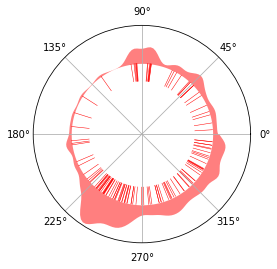

In [11]:
color_map = {'tumor': {78: "red"},}
cyclum.illustration.plot_round_distr_color(pseudotime, label['tumor'], color_map['tumor'])
pass

In [12]:
sttpm2 = sttpm - np.concatenate([np.cos(pseudotime + i * 2 * np.pi / 3) for i in range(3)], axis=1) @ rotation

## Propose genes
We show the top 20 proposed gene here.

In [13]:
weight = np.sqrt((rotation[0, ] - rotation[1, ] / 2 - rotation[2, ] / 2) ** 2 + 
                 3 * (rotation[1, ] - rotation[2, ]) ** 2 / 4 + 1e-12)
order = list(reversed(np.argsort(weight)))
for i in order[1:20]:
    print(sttpm.columns.tolist()[i])

UGDH-AS1
NME1
LOC100131257
FBLIM1
ORC4
ATP5G3
MAB21L3
ABCC9
FABP5
C1QBP
LSM10
REXO1L1
ATP5G1
TOMM5
NDUFA8
TLCD2
S100A11
COX6C
LOC646214


## AXL/MITF program
We show that cyclum helps clarify AXL/MITF contrast.

In [14]:
with open('data/melanoma/AXL_marker_genes.txt') as file:
    axl_genes = file.read().splitlines()
with open('data/melanoma/MITF_marker_genes.txt') as file:
    mitf_genes = file.read().splitlines()

In [15]:
sttpm3 = sttpm2[label['malignant(1=no,2=yes,0=unresolved)'] == 2]

array([[ 1.        , -0.23826302],
       [-0.23826302,  1.        ]])

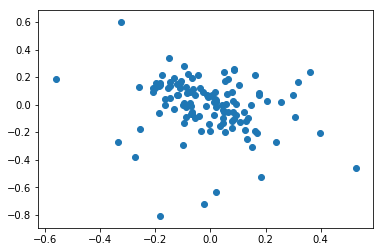

In [20]:
axl_score = sttpm3[axl_genes].mean(axis=1) - sttpm3.mean(axis=1)
mitf_score = sttpm3[mitf_genes].mean(axis=1) - sttpm3.mean(axis=1)
plt.scatter(axl_score, mitf_score)
np.corrcoef(axl_score, mitf_score)

array([[1.        , 0.23976131],
       [0.23976131, 1.        ]])

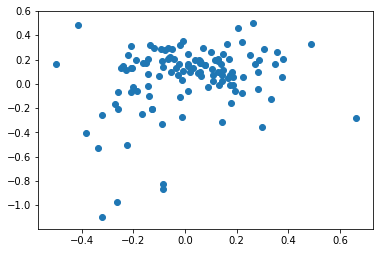

In [19]:
sttpm4 = sttpm[label['malignant(1=no,2=yes,0=unresolved)'] == 2]
axl_score = sttpm4[axl_genes].mean(axis=1) - sttpm4.mean(axis=1)
mitf_score = sttpm4[mitf_genes].mean(axis=1) - sttpm4.mean(axis=1)
plt.scatter(axl_score, mitf_score)
np.corrcoef(axl_score, mitf_score)